## Mean and Standard Deviation of the images

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
os.listdir("./Dataset/archive/training/training")

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [3]:
training_dataset_path = "./Dataset/archive/training/training"

In [4]:
training_transforms = transforms.Compose([
    # This will change the dimensions of all the images to 224 X 224
    transforms.Resize((224, 224)), 
    # This change the data type of the values in the images from numpy to Tensor
    transforms.ToTensor()
    ])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(
    # root: Path for the training dataset
    root = training_dataset_path, 
    # Adding the transforms on all the images in the dataset
    transform = training_transforms
    )

In [6]:
# Getting the data ready for the ML model
train_loader = torch.utils.data.DataLoader(
    # Variable of the dataset
    dataset = train_dataset,
    # Defining the batch size
    batch_size = 32,
    shuffle = False
    )

The method we using will give us the approx mean and standard deviation. We can get the accurate mean and std by taking all the images instead in batches.

In [7]:
def get_mean_and_std(loader):
    # Initiating the mean, std and total_images_count with 0
    mean = 0
    std = 0
    total_images_count = 0

    # Looping through the batchs of pictures
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        # Reshaping the images from (32, 3, 224, 224) -> (32, 3, 224 X 224)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        # Getting the mean of the values from the 3rd dimension
        mean += images.mean(2).sum(0)
        # Getting the std of the values from the 3rd dimension
        std += images.std(2).sum(0)
        # Summing the number of all the images in all the batches
        total_images_count += image_count_in_a_batch

    # Taking average of both the values
    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [8]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2037]))

## Image Data Preparation

In [9]:
import torchvision
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Paths to the Training and Test Datasets

train_dataset_path = "./Dataset/archive/training/training"
test_dataset_path = "./Dataset/archive/validation/validation"

In [11]:
# image = (image - mean) / std

mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2037]

train_transforms = transforms.Compose([
    # Reshaping all the images to 224 X 224 size
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # If we are not passing any values,
                                       # It will by default Flip the images with 50% prob.
    transforms.RandomRotation(10), # Random Rotation to 10 degrees
    # Changing the data type from numpy array to tensor
    transforms.ToTensor(),
    # Normalizing the images using the mean and std that we found in the previous part
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

# In the test dataset we do not need to do augmentation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [12]:
# Defining the custom dataset and also adding the transforms

train_dataset = torchvision.datasets.ImageFolder(
    root = train_dataset_path,
    transform = train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    root = test_dataset_path,
    transform = test_transforms
)

In [13]:
def show_transformed_images(dataset):
    # Splitting the dataset into batches of 6
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = 6,
        shuffle = True
    )
    batch = next(iter(loader))
    # Taking the image and the label of each images from the batch
    images, labels = batch

    # Defining the number of images in each row
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11, 11))

    # Shape of the Images is (3, 224, 224), we need (224, 224, 3) as it will be easy to plot
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print("Labels : ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels :  tensor([7, 4, 3, 1, 0, 1])


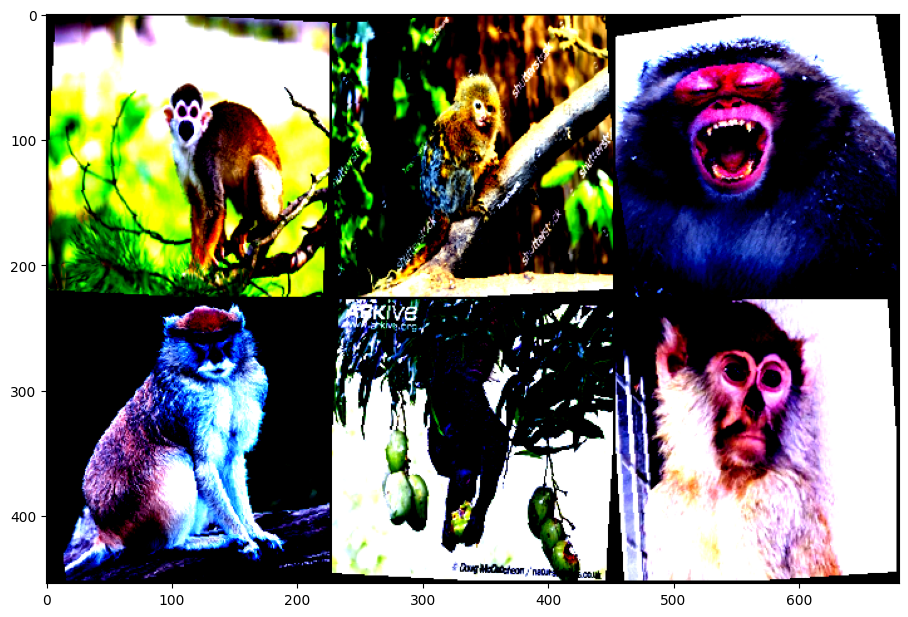

In [14]:
show_transformed_images(train_dataset)

In [15]:
# Making the custom loader with 32 batch size

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = True
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = False
)

## Neural Network

In [16]:
# Setting the GPU, if it's available
def set_device():
    if torch.cuda.is_available():
        dev = "cude:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [17]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Importing the pre-trained layers of the ResNet-18 Model
resnet18_model = models.resnet18(pretrained = True)

# Here we are retrieving the number of units in the last fully connected layer in the ResNet model
# In ResNet model, the final layer has 1000 units
num_features = resnet18_model.fc.in_features

# Number of units we need in our output layer
number_of_classes = 10

# Adding our layer in the end of the ResNet Model
resnet18_model.fc = nn.Linear(num_features, number_of_classes)

device = set_device()

resnet18_model = resnet18_model.to(device)

# Loss function for Multiple Classfication
loss_fn = nn.CrossEntropyLoss()

# Optimizer with the learning rate of 0.01
optimizer = optim.SGD(
    resnet18_model.parameters(),
    lr = 0.01,
    momentum = 0.9,
    weight_decay = 0.003
)

c:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Function to evaluate our model on the test dataset
def evaluate_model_on_test(model, test_loader):

    # Setting the model to evaluation mode
    model.eval()

    # Initiating variables to keep track of the correct predictions in each epoch and total images
    predicted_correctly_on_epoch = 0
    total = 0

    device = set_device()

    # Disabling the Gradient Descent for evaluation to save memory and computation
    with torch.no_grad():

        # Unpacking the data: Images (input) and labels (true outputs)
        for data in test_loader:
            images, labels = data

            # Moving Images and labels to appropriate device
            images = images.to(device)
            labels = labels.to(device)

            # Incrementing the total amount of images
            total += labels.size(0)
            
            # Forward Pass: Get the model predctions on the test images
            outputs = model(images)

            # Getting the class label with the highest prediction score
            _, predicted = torch.max(outputs.data, 1)

            # Counting how many correct predictions are made by the model
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    
    # Calculating the accuracy of the model as the percentage of correct predictions over the total samples
    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    
    print("     - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
          % (predicted_correctly_on_epoch, total, epoch_acc))

In [19]:
# Functoin to train a neural Network
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()

    # Loop over the number of epochs
    for epoch in range(n_epochs):
        print("Epoch number %d" %(epoch + 1)) # Display the Current Loop Number

        # Set the Model to train mode
        model.train()

        # Setting up variables to keep track of loss and accuracy
        running_loss = 0
        running_correct = 0
        total = 0

        # Iterae over the batches of data from the training loader
        for data in train_loader:

            # Unpacking data into images and labels
            images, labels = data

            # Moving images and labels to the appropriate device
            images = images.to(device)
            labels = labels.to(device)

            # Incrementing the number of images seen in the epoch
            total += labels.size(0)

            # Zero the gradient from the previous iteration
            optimizer.zero_grad()

            # Forward Pass: Get the model predictions for the current batch of images
            outputs = model(images)

            # Get the predicted class label by selecting the maximum value among the class dimension
            _, predicted = torch.max(outputs.data, 1)

            # Calculate the loss between the predicted and true labels
            loss = criterion(outputs, labels)

            # Backpropogate the loss to compute the gradient
            loss.backward()

            # Upadte the weights based on the gradients using optimizer
            optimizer.step()

            # Accumulate the running loss for each epoch
            running_loss += loss.item()

            # Accumulate the total number of true predictions
            running_correct += (labels == predicted).sum().item()

        # Calculate the average loss for each epoch
        epoch_loss = running_loss / len(train_loader)

        # Calculate the accuracy for each epoch
        epoch_acc = 100 * running_correct / total

        print("     - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))
        
        # Evaluate the model on the test dataset after each training epoch
        evaluate_model_on_test(model, test_loader)

    # Print a message when the training ia completed
    print("Finished")

    # Return the training model
    return model

In [21]:
model = train_nn(resnet18_model, 
                 train_loader = train_data_loader,
                 test_loader = test_data_loader,
                 criterion = loss_fn,
                 optimizer = optimizer,
                 n_epochs = 4)

Epoch number 1
     - Training dataset. Got 1092 out of 1097 images correctly (99.544%). Epoch loss: 0.017
     - Testing dataset. Got 262 out of 272 images correctly (96.324%)
Epoch number 2
     - Training dataset. Got 1093 out of 1097 images correctly (99.635%). Epoch loss: 0.013
     - Testing dataset. Got 267 out of 272 images correctly (98.162%)
Epoch number 3
     - Training dataset. Got 1092 out of 1097 images correctly (99.544%). Epoch loss: 0.014
     - Testing dataset. Got 267 out of 272 images correctly (98.162%)
Epoch number 4
     - Training dataset. Got 1095 out of 1097 images correctly (99.818%). Epoch loss: 0.011
     - Testing dataset. Got 263 out of 272 images correctly (96.691%)
Finished
